# Boston Housing Price Prediction

The dataset originates from the UCI Machine Learning Repository, was collected from homes in suburbs of Boston, Massachusetts in 1978. The data consists of 506 entries, wherein each row has 14 features.

This data is quite straightforward. Therefore, we teak it a little bit to increase the complexity of the problem. First, we use SMOTE to increase the size of the original dataset. Second, we randomly remove some cells in rows. Third, we also add noise to the dataset to generate some outlier samples.

***References:***
- https://www.kaggle.com/datasets/schirmerchad/bostonhoustingmlnd

|Column   | Description                                                           |
|---------|-----------------------------------------------------------------------|
| CRIM    | Per capita crime rate by town                                         |
| ZN      | Proportion of residential land zoned for lots over 25,000 sq.ft.      |
| INDUS   | Proportion of non-retail business acres per town                      |
| CHAS    | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX     | Nitric oxides concentration (parts per 10 million)                    |
| RM      | Average number of rooms per dwelling                                  |
| AGE     | Proportion of owner-occupied units built prior to 1940                |
| DIS     | Weighted distances to five Boston employment centres                  |
| RAD     | Index of accessibility to radial highways                             |
| TAX     | Full-value property-tax rate per $10,000                              |
| PTRATIO | Pupil - teacher ratio by town                                         |
| B       | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town        |
| LSTAT   | % lower status of the population                                      |
| MEDV    | Median value of owner-occupied homes in $1000's                       |

In [1]:
from random import seed
from random import randrange
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error 

## 1. Dataset Preprocessing
We use a synthesized version of the original dataset, which is 10X bigger and has outlier and missing values.

In [2]:
# Skewness of each attribute
# cols = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV"]
rawdata = pd.read_csv('data/housing_10X_outlier_missing.csv', header=0)
rawdata[rawdata == -1] = np.nan
rawdata.skew().abs().sort_values()

Unnamed: 0    0.000000
INDUS         0.328033
AGE           0.602727
NOX           0.604129
RM            0.617902
TAX           0.685351
PTRATIO       0.824477
LSTAT         0.826507
DIS           0.960124
RAD           1.028169
MEDV          1.196348
ZN            2.222976
B             2.926272
CHAS          3.051357
CRIM          4.972343
dtype: float64

### 1.1 Filling missing data & remove outlier

- Replace all missing data (values written as '-1') in the csv file as NaN.
- To process outlier, we should consider skewness of each feature. 
- Outlier detection: 
    - q3 = np.nanpercentile(data.loc[:,var], 75) #q3 w/o NaN's
    - q1 = np.nanpercentile(data.loc[:,var], 25) #q1 w/o NaN's
    - threshold = (q3 - q1) * 1.5
    - valid_data = [q1 - threshold, threshold + q3]
- Outlier values are replaced by either mean or median value
    - Skewness <= 1, mean should be used to process outlier
    - Skewness > 1, median should be used to process outlier 


In [12]:
# load data from csv 
def load_csv(filename, cols=None, header=None):
    data = pd.read_csv(filename, header=header, names=cols)

# 0. make all '-1' into NaN (so that -1 does not affect calculations of correlation, mean, median)
    data[data == -1] = np.nan

# 1. for 'CHAS', just fill in missing data with median
    for row in range(data.shape[0]):
        if np.isnan(data.loc[row,'CHAS']):
            data.loc[row,'CHAS'] = data.loc[:,'CHAS'].median()

# 2. for other attributes, calculate skewness of each, and impute median/mean accordingly
    for var in data.columns.drop('CHAS'):
        abs_skew = abs(data.loc[:,var].skew()) # absolute skewness
        med_value = data.loc[:,var].median()  # median without NaN's
        mean_value = data.loc[:,var].mean()  # mean without NaN's
        
        # 2.1 find out outliers, fill with median/mean based on skewness (except CHAS)
        # 2.2 impute missing data (NaN) with median/mean based on skewness 
        q3 = np.nanpercentile(data.loc[:,var], 75) #q3 w/o NaN's
        q1 = np.nanpercentile(data.loc[:,var], 25) #q1 w/o NaN's
        iqr = q3-q1
            
        if abs_skew > 1: # for highly skewed attributes -> impute median
            for i in range(data.shape[0]):
                if data.loc[i,var] > q3 + 1.5*iqr or data.loc[i,var] < q1 - 1.5*iqr:
                    data.loc[i,var] = med_value
                
                # fill in NaN with median
                if np.isnan(data.loc[i,var]):
                    data.loc[i,var] = med_value

        else: # for not too skewed attributes -> impute mean
            for i in range(data.shape[0]):
                if data.loc[i,var] > q3 + 1.5*iqr or data.loc[i,var] < q1 - 1.5*iqr:
                    data.loc[i,var] = mean_value
                    
                # fill in NaN with mean
                if np.isnan(data.loc[i,var]):
                    data.loc[i,var] = mean_value
        
    return data

In [13]:
processed_data = load_csv('data/housing_10X_outlier_missing.csv', header=0)

### 1.2 Dataset preparation

In [27]:
X = processed_data.iloc[:,1:14]
y = processed_data['MEDV']

In [15]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 2. Model Execution

Here, we select three algorithms:
- Decision Tree
- Random Forest
- XGBoost

In [21]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [32]:
dtree = DecisionTreeRegressor().fit(X_train, y_train)
dt_pred = dtree.predict(X_test)
print("mae loss of decision tree", mae(dt_pred, y_test))

mae loss of decision tree 0.189690274058911


In [33]:
# define random forest regressor
regressor_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=10, random_state=0)
                       # n_estimators = number of trees
rfc = regressor_rf.fit(X_train, y_train)
y_pred = regressor_rf.predict(X_test)
mae_loss = mae(y_pred, y_test)  # Evaluating the Algorithm by SKLearn
print("mae loss of random forest:%.2f" % mae_loss)

mae loss of random forest:1.65


In [54]:
xgb_model = xgb.XGBRFRegressor().fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("mae loss of xgb", mae(xgb_pred, y_test))

mae loss of xgb 1.3911201442897285


## 3. Feature Engineering

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

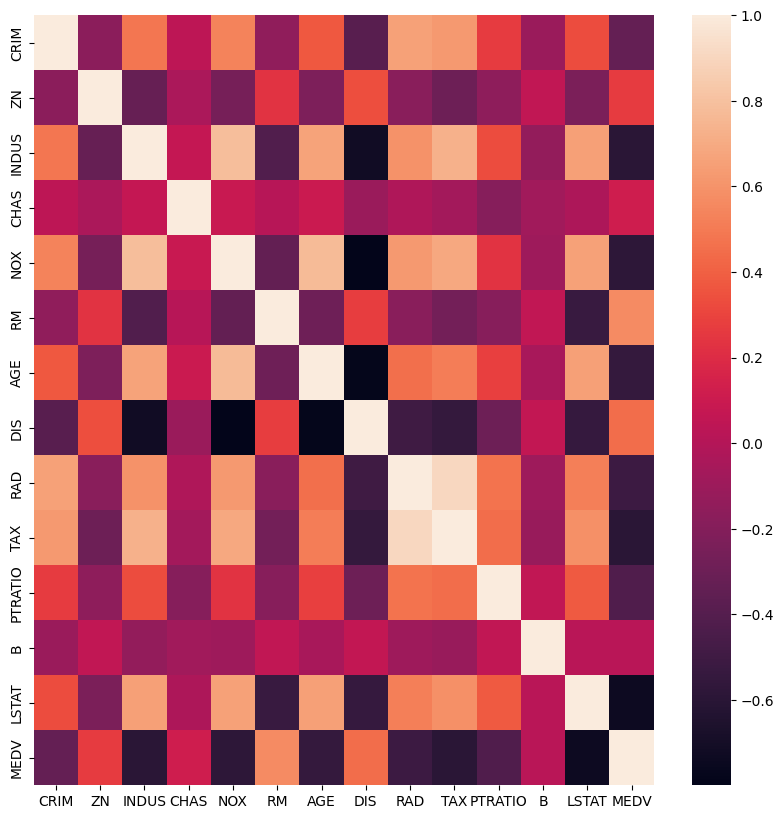

In [38]:
corr = processed_data.iloc[:,1:].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr)
plt.show()

***Strategy 1: Select high correlated features using Pearson Correlation***

In [39]:

# get abs(correlation) between attributes and MEDV
full_data_corr_wMEDV = corr.iloc[13,:13].abs().sort_values(ascending = False) 
full_data_corr_wMEDV

# get attributes certain high and moderate correlation:
high_corr_var = full_data_corr_wMEDV[full_data_corr_wMEDV > 0.5].keys() 
high_corr_var

Index(['LSTAT', 'INDUS', 'TAX', 'NOX', 'RM', 'AGE', 'RAD'], dtype='object')

In [43]:
xgb_model2 = xgb.XGBRFRegressor().fit(X_train[['LSTAT', 'INDUS', 'TAX', 'NOX', 'RM', 'AGE', 'RAD']], y_train)
xgb_pred2 = xgb_model2.predict(X_test[['LSTAT', 'INDUS', 'TAX', 'NOX', 'RM', 'AGE', 'RAD']])
print("mae loss of xgb", mae(xgb_pred2, y_test))

mae loss of xgb 1.448411547423067


***Strategy 2: Using Feature Selection Feature of Sklearn***

In [45]:
from sklearn.feature_selection import RFE

In [47]:
xgb_model2 = xgb.XGBRFRegressor()
feature_engine = RFE(xgb_model2, n_features_to_select=5)
x_train_rfe = feature_engine.fit_transform(X_train, y_train)
x_test_rfe = feature_engine.transform(X_test)
xgb_model2.fit(x_train_rfe, y_train)
rfe_pred = xgb_model2.predict(x_test_rfe)
print("mae loss of xgb w/ rfe", mae(rfe_pred, y_test))

mae loss of xgb w/ rfe 1.5298372418510826


In [50]:
lowest = 9999
best_n = -1
for i in range(13):
    temp_model = xgb.XGBRFRegressor()
    eng = RFE(temp_model, n_features_to_select=i+1)
    x_train_rfe = eng.fit_transform(X_train, y_train)
    x_test_rfe = eng.transform(X_test)
    temp_model.fit(x_train_rfe, y_train)
    rfe_pred = temp_model.predict(x_test_rfe)
    score = mae(rfe_pred, y_test)
    if score < lowest:
        best_n = i + 1
        lowest = score
print(lowest, best_n)

1.3735682632496726 11


In [51]:
lowest = 9999
best_n = -1
for i in range(13):
    temp_model = DecisionTreeRegressor()
    eng = RFE(temp_model, n_features_to_select=i+1)
    x_train_rfe = eng.fit_transform(X_train, y_train)
    x_test_rfe = eng.transform(X_test)
    temp_model.fit(x_train_rfe, y_train)
    rfe_pred = temp_model.predict(x_test_rfe)
    score = mae(rfe_pred, y_test)
    if score < lowest:
        best_n = i + 1
        lowest = score
print(lowest, best_n)

0.18947595061743966 13


## 4. Model Explanation
We will explain model prediction using SHAP

In [53]:
import shap
shap.initjs()

### 4.1 SHAP Initialization

In [55]:
# shap will automatically select explainer for a given model.
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

Here, we show a global view of feature importance.
1. Bee plot helps us understand outcome values corresponding to high/low values of features
2. Bar plot presents a global view of feature importance, which don't consider sign (pos/neg) of the contribution.

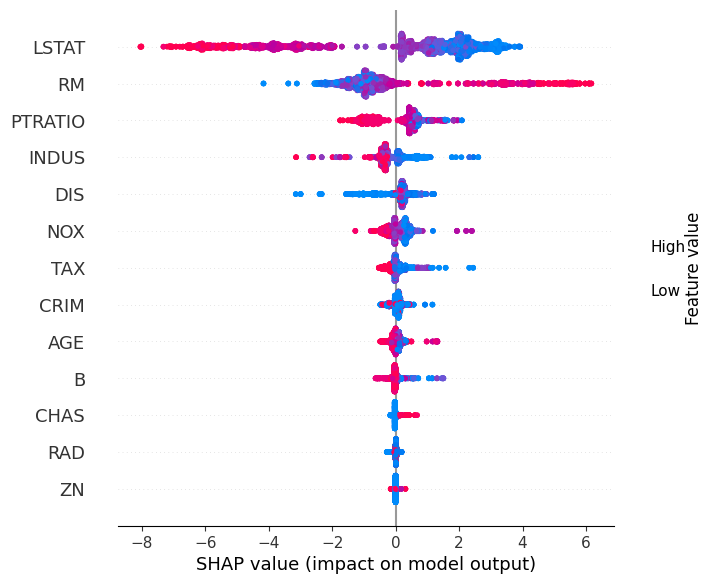

In [56]:
shap.summary_plot(shap_values)

As can be seen, higher LSTAT values correspond to lower SHAP values. LSTAT is the ratio of lower status of the population. It means that the more low-income population is, the less the price is. Similarly, the bigger the more expensive.

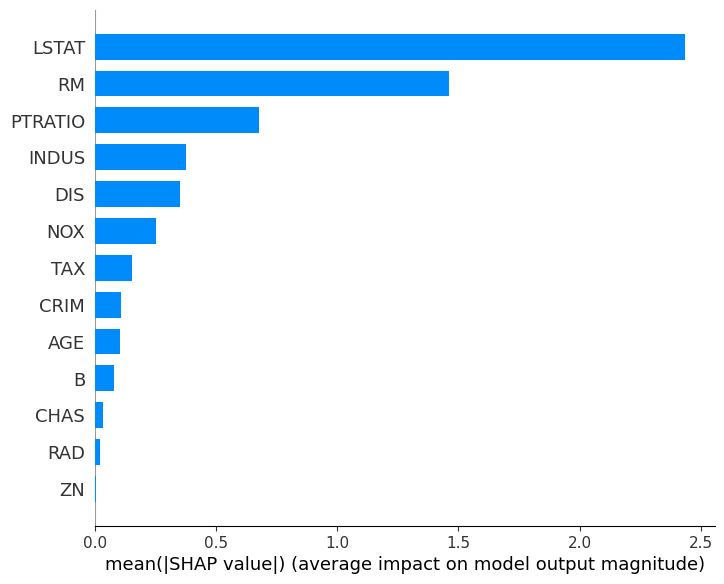

In [57]:
shap.summary_plot(shap_values, plot_type='bar')

***Then, we show attribution of instance predictions***

In [61]:
shap.force_plot(explainer.expected_value, shap_values[0].values, features=X_train.columns)

In [62]:
shap.force_plot(explainer.expected_value, shap_values[100].values, features=X_train.columns)